In [2]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

In [3]:
ra_dat = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/ra_BKG-EDR-dr8.npz')
ra_BKG = ra_dat['arr_0']
print(len(ra_BKG))
print('ra done')

dec_dat = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/dec_BKG-EDR-dr8.npz')
dec_BKG = dec_dat['arr_0']
print(len(dec_BKG))
print('dec done')

# psfdepth_z_dat = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/240-280/CATS/psfdepth_z_BKG-240-260-dr9.npz')
# psfdepth_z_BKG = psfdepth_z_dat['arr_0']
# print(len(psfdepth_z_BKG))
# print('psfdepth z done')

galdepth_z_dat = np.load('/Users/mtownsend/Documents/LRG_Data/expanded-data/new-cats/galdepth_z_BKG-EDR-dr8.npz')
galdepth_z_BKG = galdepth_z_dat['arr_0']
print(len(galdepth_z_BKG))
print('galdepth z done')




3652790
ra done
3652790
dec done
3652790
galdepth z done


In [5]:
 # make EDR cuts
    
ra_EDR = ra_BKG[np.where((ra_BKG >= 240.) & (ra_BKG <= 247.) & (dec_BKG >= 5.5) & (dec_BKG <= 12.5))]
dec_EDR = dec_BKG[np.where((ra_BKG >= 240.) & (ra_BKG <= 247.) & (dec_BKG >= 5.5) & (dec_BKG <= 12.5))]
# psfdepth_z_EDR = psfdepth_z_BKG[np.where((ra_BKG >= 240.) & (ra_BKG <= 247.) & (dec_BKG >= 5.5) & (dec_BKG <= 12.5))]
galdepth_z_EDR = galdepth_z_BKG[np.where((ra_BKG >= 240.) & (ra_BKG <= 247.) & (dec_BKG >= 5.5) & (dec_BKG <= 12.5))]

print(len(ra_EDR))
print(len(dec_EDR))
# print(len(psfdepth_z_EDR))
print(len(galdepth_z_EDR))


1758516
1758516
1758516


In [6]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# ra_cut = ra[np.where(zmag <= 21.5)]
# dec_cut = dec[np.where(zmag <= 21.5)]

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra_EDR)):
    theta.append(np.radians(90. - dec_EDR[i]))
    phi.append(np.radians(ra_EDR[i]))

print('length phi: ', len(phi))
# Convert angles theta and phi to pixel numbers
pixnums = hp.ang2pix(nside, theta, phi, nest=True)
print('pixnums: ', pixnums)
print(pixnums[0])
print('length pixnums: ', len(pixnums))


# Create a HEALPix map from pix
mapp = np.bincount(pixnums, minlength=npixel)
# print('map where ne 0: ', mapp[np.where(mapp > 0)])
# print('length map == 0: ', len(mapp[np.where(mapp == 0)]))
# print('length map: ', len(mapp))

# masked_map = np.zeros(len(mapp))
# masked_map[(mapp == 0)] = 1

# m = hp.ma(mapp)
# m.mask = masked_map



length phi:  1758516
pixnums:  [8075477 8075477 8075478 ... 8112885 8112887 8113035]
8075477
length pixnums:  1758516


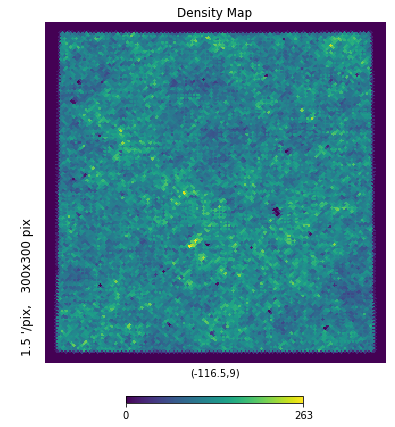

In [14]:
# Plot mapp
hp.gnomview(mapp, xsize=300, ysize=300, rot=(-116.5, 9.), flip='astro', nest=True, title='Density Map')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-bin1.pdf')
plt.show()

In [15]:
# This section maps various values of the galaxies into a HEALPix map so the result is basically a density map of
# galaxy properties. In this code the new maps are array_g, array_r, and array_z.

# returns indices that would sort the array pixnums
pixorder = np.argsort(pixnums)
# returns sorted unique values of pixnums, indices to reconstruct the original array from the unique array,
# and the number of times each unique value comes up in the original array
pixels, pixinverse, pixcnts = np.unique(pixnums, return_inverse=True, return_counts=True)

# print(len(pixnums))
# print('----')
# print(pixorder)
# print('----')
# print(len(pixels))
# print('----')
# print(pixcnts)
# inserts a zero in the zeroth index space, moving all other values down the line
pixcnts = np.insert(pixcnts, 0, 0)
# calculates the cumulative sum of the values in pixcnts
pixcnts = np.cumsum(pixcnts)
# print(pixcnts)

# This seems like a weird thing to do, but this is why: pixnums is an array of pixel numbers that correspond to a
# galaxy. There are many galaxies per pixel, so the individual pixnum will repeat. pixcnts is the number of times
# each unique value appears in pixnums. pixorder is the array of indices that would sort pixnums. The loop below makes
# a map of median values per pixel for any desired characteristic. In the loop, inds is the index array of galaxies
# that show up in a pixel (the pixnum values). It uses the range set by pixcnts to determine which index from
# pixorder is used. In the loop, pix is the pixel number inds belongs in.

array_g = np.full(npixel, -1.)
array_r = np.full(npixel, -1.)
array_z = np.full(npixel, -1.)
pix = []
for i in range(len(pixcnts)-1):
# for i in range(1):
    inds = pixorder[pixcnts[i]:pixcnts[i+1]]
#     print(inds)
    pix = pixnums[inds][0]
#     print(pix)
    array_g[pix] = -2.5 * (np.log10(5./np.sqrt(np.median(galdepth_z_EDR[inds]))) - 9.)
#     array_r[pix] = np.median(trans_r_BKG1[inds])
#     array_z[pix] = np.median(zmag_BKG1[inds])
    # array_g[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_g[inds]))) - 9.)
    # array_r[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_r[inds]))) - 9.)
    # array_z[pix] = -2.5*(np.log10(5. / np.sqrt(np.median(galdepth_z[inds]))) - 9.)

# print(array_g[array_g != -1])
# print(array_r[array_r != -1])
# print(array_z[array_z != -1])

masked_map_g = np.zeros(len(array_g))
masked_map_g[(array_g == -1.)] = 1

mg = hp.ma(array_g)
mg.mask = masked_map_g

# masked_map_r = np.zeros(len(array_r))
# masked_map_r[(array_r == -1.)] = 1

# mr = hp.ma(array_r)
# mr.mask = masked_map_r

# masked_map_z = np.zeros(len(array_z))
# masked_map_z[(array_z == -1.)] = 1

# mz = hp.ma(array_z)
# mz.mask = masked_map_z

# # hp.gnomview(mg, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median gmag (nobs >= 2)')
# # plt.show()
# #
# # hp.gnomview(mr, xsize=225, ysize=225, rot=(-116.5, 9.), flip='geo', nest=True, title='Median rmag (nobs >= 2)')
# # plt.show()

# This HEALPix image shows the median zmag in each pixel

# hp.gnomview(mz, flip='astro', xsize=5000, ysize=3500, rot=(156., 12.), nest=True, title='BIN1-Median zmag')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-zmag-bin1.pdf')
# plt.show()

# hp.gnomview(mr, flip='astro', xsize=5000, ysize=3500, rot=(156., 12.), nest=True, title='BIN1-Median r transmission')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-r-trans-bin1.pdf')
# plt.show()

# hp.gnomview(mz, flip='astro', xsize=5000, ysize=3500, rot=(156., 12.), nest=True, title='BIN1-Median z transmission')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-z-trans-bin1.pdf')
# plt.show()

# hp.gnomview(mg, flip='astro', xsize=5000, max=0.8, ysize=3500, rot=(156., 12.), nest=True, title='BIN1-Median g transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-g-trans-80-bin1.pdf')
# plt.show()

# hp.gnomview(mr, flip='astro', xsize=5000, max=0.8, ysize=3500, rot=(156., 12.), nest=True, title='BIN1-Median r transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-r-trans-80-bin1.pdf')
# plt.show()

# hp.gnomview(mz, flip='astro', xsize=5000, max=0.8, ysize=3500, rot=(156., 12.), nest=True, title='BIN1-Median z transmission (80%)')
# plt.savefig('/Users/mtownsend/Desktop/HEALPix-median-z-trans-80-bin1.pdf')
# plt.show()



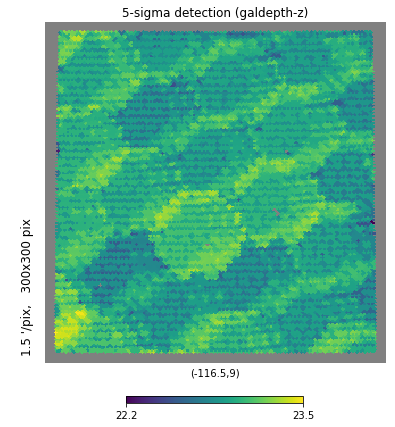

In [16]:
# Plot mapp
hp.gnomview(mg, xsize=300, ysize=300, rot=(-116.5, 9.), flip='astro', nest=True, title='5-sigma detection (galdepth-z)')
# plt.savefig('/Users/mtownsend/Desktop/psfdepth-median-psfdepth.pdf')
plt.show()


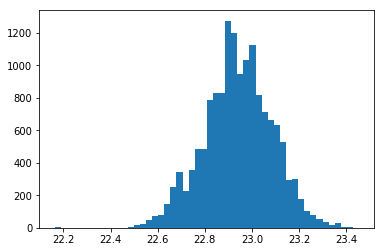

22.9394493565266


In [17]:
plt.hist(array_g[np.where(array_g != -1)], bins=50)
plt.show()

print(np.median(array_g[np.where(array_g != -1)]))

percentile:  22.751825165676685


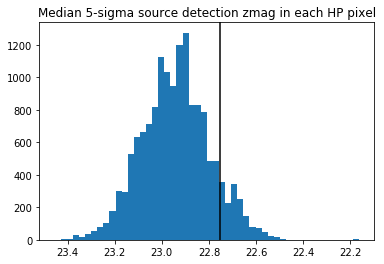

22.9394493565266


In [18]:
# This section isolates the top 98 percent brightest sources in zmag. array_z is a map of median values for zmag for
# each HEALPix pixel.

zmag = array_g[np.where(array_g != -1)]

# sort zmag array
sort_zmag = np.sort(zmag)
# find 90th percentile value
cutlen_z2 = np.percentile(sort_zmag, 10)
print('percentile: ', cutlen_z2)

plt.hist(array_g[np.where(array_g != -1)], bins=50)
plt.title("Median 5-sigma source detection zmag in each HP pixel")
plt.axvline(cutlen_z2, c='black')
plt.gca().invert_xaxis()
# plt.text(22.75,15000, '{} mag'.format(round(cutlen_z2,2), fontsize=12))
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/08April2021/hist-0to40-5sig.pdf')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/08April2021/hist-bin0-5sig.pdf')

plt.show()

print(np.median(array_g[np.where(array_g != -1)]))



# ra90 = ra_BKG0[np.where(zmag_BKG0 <= cutlen_z2)]
# dec90 = dec_BKG0[np.where(zmag_BKG0 <= cutlen_z2)]

# phi90 = []
# theta90 = []

# for i in range(len(ra90)):
#     theta90.append(np.radians(90. - dec90[i]))
#     phi90.append(np.radians(ra90[i]))

# # Convert angles theta and phi to pixel numbers
# pixnums98 = hp.ang2pix(nside, theta98, phi98, nest=True)

# # Create a HEALPix map from pix
# density_map98 = np.bincount(pixnums98, minlength=npixel)